# Advanced deep learning for computer vision

## Three essential computer vision tasks

## An image segmentation example

```python

!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

```

In [1]:
import os

```python

input_dir = "images/"
target_dir = "annotations/trimaps/"

input_img_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".jpg")])
target_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".png") and not fname.startswith(".")])

```

In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

ds, ds_info = tfds.load(
    'oxford_iiit_pet',
    split='train',
    with_info=True
)

In [8]:
# محاسبه ۱٪ از دیتاست
total_samples = ds_info.splits['train'].num_examples
print(f"تعداد کل نمونه‌ها: {total_samples}")
percentage = 10  # 10%
num_samples = int(total_samples * percentage / 100)
print(f"تعداد نمونه‌های انتخابی : {num_samples}")

تعداد کل نمونه‌ها: 3680
تعداد نمونه‌های انتخابی : 368


In [9]:

# تصادفی‌سازی و انتخاب نمونه‌ها
ds = ds.shuffle(buffer_size=total_samples, seed=42).take(num_samples)

In [10]:
from tensorflow.keras.utils import load_img, img_to_array

```python
import matplotlib.pyplot as plt

plt.axis("off")
plt.imshow(load_img(input_img_paths[9]))

```

```python
def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])

img = img_to_array(load_img(target_paths[9], color_mode="grayscale"))
display_target(img)
```

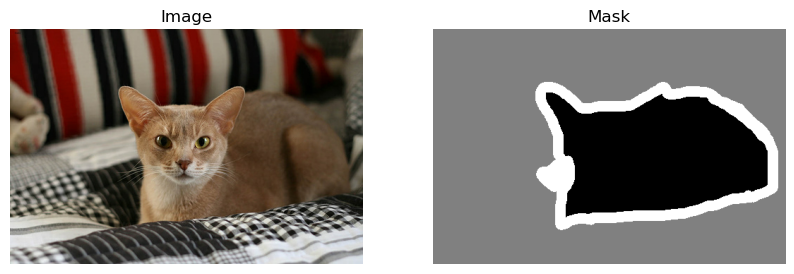

In [11]:
# مشاهده یک نمونه
for example in ds.take(1):
    image = example['image']
    mask = example['segmentation_mask']

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image.numpy())
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask.numpy().squeeze(), cmap='gray')
    plt.title("Mask")
    plt.axis("off")

    plt.show()

```python

import numpy as np
import random

img_size = (200, 200)
num_imgs = len(input_img_paths)

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1
    return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

```

In [12]:
import numpy as np
import random

img_size = (200, 200)

examples = list(ds)  
num_imgs = len(examples)

random.Random(1337).shuffle(examples)

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets    = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")

for i, ex in enumerate(examples):
    # تصویر ورودی
    img = tf.image.resize(ex['image'], img_size)      # resize
    img = img / 255.0                                  # نرمال‌سازی 0–1
    input_imgs[i] = img.numpy().astype("float32")

    # ماسک
    m  = tf.image.resize(ex['segmentation_mask'], img_size, method='nearest')
    m  = m.numpy().astype("uint8") - 1                 # برچسب‌ها را صفر و یک می‌کند
    targets[i] = m

num_val_samples = 100
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [13]:
# 8. چک کردن ابعاد نهایی
print("train_input_imgs:", train_input_imgs.shape)
print("train_targets   :", train_targets.shape)
print("val_input_imgs  :", val_input_imgs.shape)
print("val_targets     :", val_targets.shape)

train_input_imgs: (268, 200, 200, 3)
train_targets   : (268, 200, 200, 1)
val_input_imgs  : (100, 200, 200, 3)
val_targets     : (100, 200, 200, 1)


In [14]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)

    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 100, 100, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 25, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 25, 25, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 50, 50, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 50, 50, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 100, 100, 128)  │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 100, 100, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 200, 200, 64)   │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 200, 200, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,880,643 (10.99 MB)

 Trainable params: 2,880,643 (10.99 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",
                                    save_best_only=True)
]

history = model.fit(train_input_imgs, train_targets,
                    epochs=50,
                    callbacks=callbacks,
                    batch_size=64,
                    validation_data=(val_input_imgs, val_targets))

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 27s 5s/step - loss: 1.0908 - val_loss: 1.0546
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 26s 5s/step - loss: 1.0297 - val_loss: 0.9443
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 26s 5s/step - loss: 0.9375 - val_loss: 0.9470
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - loss: 0.9329 - val_loss: 0.9343
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - loss: 0.9235 - val_loss: 0.9404
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - loss: 0.9290 - val_loss: 0.9371
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - loss: 0.9295 - val_loss: 0.9345
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step - loss: 0.9232 - val_loss: 0.9392
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - loss: 0.9259 - val_loss: 0.9343
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - loss: 0.9234 - val_loss: 0.9311
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - loss: 0.9239 - val_loss: 0.9356
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 26s 5s/step - loss: 0.9231 - val_loss: 0.9311
Epoch 13/50
5

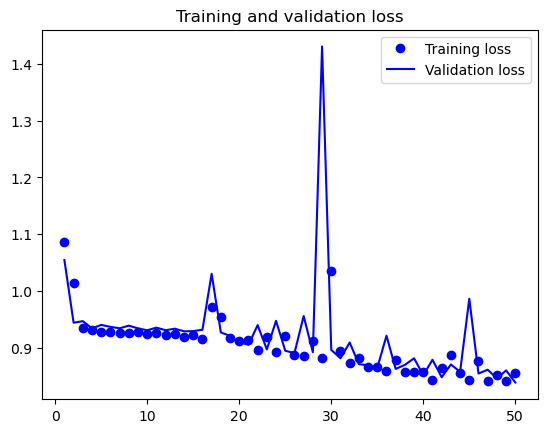

In [16]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


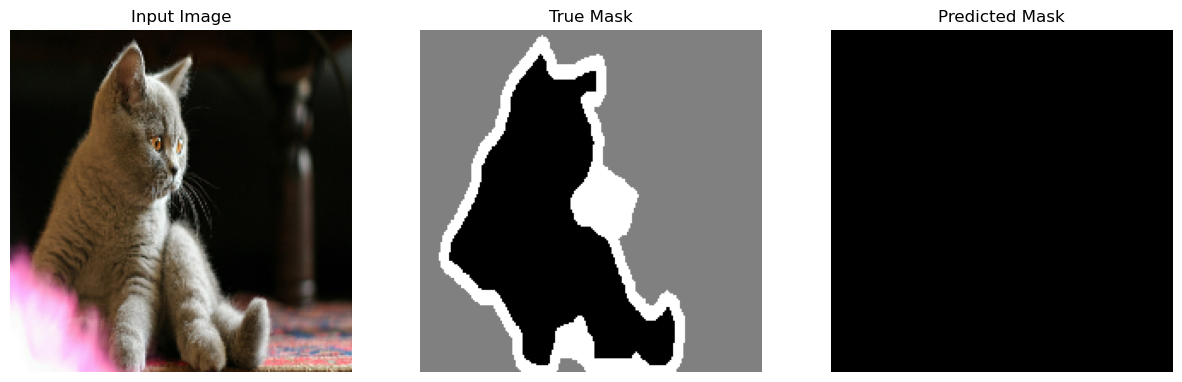

In [19]:
from tensorflow.keras.utils import array_to_img

model = tf.keras.models.load_model("oxford_segmentation.keras")

# ایندکس تصویر مورد نظر
i = 99

# گرفتن تصویر ورودی و ماسک واقعی از آرایه‌های آماده‌شده
test_image     = val_input_imgs[i]               # شکل: (200, 200, 3)
true_mask      = val_targets[i].squeeze()        # شکل: (200, 200)

# پیش‌بینی ماسک با مدل
pred = model.predict(test_image[None, ...])[0]   # خروجی شکل: (200, 200, num_classes)
pred_mask = np.argmax(pred, axis=-1)             # تبدیل احتمال به کلاس نهایی (0 یا 1)

# نمایش تصویر ورودی، ماسک واقعی و ماسک پیش‌بینی‌شده
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.axis("off")
plt.imshow(array_to_img(test_image))

plt.subplot(1, 3, 2)
plt.title("True Mask")
plt.axis("off")
plt.imshow(true_mask, cmap="gray")

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.axis("off")
plt.imshow(pred_mask, cmap="gray")

plt.show()